In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from snowballstemmer import TurkishStemmer
import string
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# Türkçe NLTK verilerini indir
nltk.download('stopwords')
nltk.download('punkt')

# Türkçe stop-word'leri tanımla
stopwords_tr = set(stopwords.words("turkish"))

# İngilizce NLTK verilerini kaldır
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Excel dosyasını oku
data = pd.read_excel("NEW_YORUM.xlsx")

# Veri setinin ilk 5 satırını göster
data.head()



,dil,tarih,oyun,kullanıcı adı,duygu,yorum
0,tr,2020-10-11 00:00:00,Mount & Blade II: Bannerlord,Cumali Koçovalı,olumlu,CO-OP GELSİN ARKADAŞLARIMIZLA AYNI HARİTADA ÖZ...
1,tr,2021-11-27 00:00:00,Mount & Blade II: Bannerlord,YeniCeriFG,olumlu,"Yerli olması bir yana, hikayesi, savaş animasy..."
2,tr,2020-10-21 00:00:00,Mount & Blade II: Bannerlord,İmparator,olumlu,Çok iyi çok beğendim.
3,tr,2020-10-18 00:00:00,Mount & Blade II: Bannerlord,Meg,olumlu,At avrat TOPUZ! O topuzun düşmanlarımın kafası...
4,tr,2020-03-30 00:00:00,Mount & Blade II: Bannerlord,Loselz,olumlu,Ortaokulda taleworlds facebook sayfasında bann...


In [ ]:
# 'yorum' sütununu 'review' değişkenine atayın
review = data["yorum"]

# Metinleri küçük harfe dönüştürün
review = review.str.lower()

# Null değerleri kontrol edin ve ekrana yazdırın
print(review.isnull().sum())




0


In [ ]:
# Null değerleri içeren satırları kaldırın
review = review.dropna()

# Metinlerdeki fazla boşlukları temizleyin
review = review.apply(lambda x: re.sub(r'\s+', ' ', x))

# Stop-word'lerin bulunduğu dosyayı okuyun
with open("stopwords.txt", "r", encoding="utf-8") as stopword_file:
    stopwords = stopword_file.read().splitlines()

# Özel karakterleri kaldıran fonksiyon tanımlayın
def remove_special_characters(text, remove_digits=True):
    # Özel karakterler ve rakamları kaldırma
    if remove_digits:
        pattern = r'[^a-zA-Z\s]'
    else:
        pattern = r'[^a-zA-Z0-9\s]'

    text = re.sub(pattern, '', text)
    return text




In [ ]:
# "yorum" sütununu içeren text_data değişkenini oluşturun
text_data = data["yorum"]


In [ ]:
# SnowballStemmer kullanarak İngilizce kök bulucu oluşturun
stemmer = SnowballStemmer("english")

# stopwords.txt dosyasını okuyarak Türkçe stop-word listesini oluşturun
with io.open("stopwords.txt", "r", encoding="utf-8") as f:
    stopwords_tr = [word.strip() for word in f.readlines()]

# Özel karakterleri kaldıran fonksiyon tanımlayın
def remove_special_characters(text):
    text = re.sub(r'[^\w\süğıçö]', '', text)  # Türkçe karakterler ve boşlukları korur
    text = re.sub(r'\d+', '', text)           # Rakamları kaldırır
    text = re.sub(r'\s+', ' ', text)          # Fazla boşlukları tek bir boşlukla değiştirir
    return text.lower()                       # Metni küçük harflere dönüştürür

# Temizlenmiş metinleri tutacak boş bir liste oluşturun
cleaned_text_data = []

# Her bir yorum metni için işlem yapın
for text in text_data:
    if isinstance(text, str):  # Eğer metin bir string ise

        # Özel karakterleri kaldırın
        text = remove_special_characters(text)

        # Metni kelimelere ayırın
        words = text.split()

        # Stop-word'leri kaldırın
        words = [word for word in words if word.lower() not in stopwords_tr]

        # Kelimelerin köklerini bulun
        stemmed_words = [stemmer.stem(word) for word in words]

        # Temizlenmiş metni tekrar oluşturun
        cleaned_text = " ".join(stemmed_words)

        # Temizlenmiş metni listeye ekleyin
        cleaned_text_data.append(cleaned_text)

        # Temizlenmiş metni ekrana yazdırın
        print("---------------------------------------------------------------------------")
        print(cleaned_text)
    else:
        cleaned_text_data.append("")  # Eğer metin değilse, boş bir string ekle



---------------------------------------------------------------------------
coop gelsi̇n arkadaşlarimizla ayni hari̇tada özel odada oynayalim başka bi̇rşey i̇stemembayildim oyuna
---------------------------------------------------------------------------
yer yana hikayesi savaş animasyonu ordu yönetm güzel olmuş güzel yanı yeni gelen modlar zevk oyun serüveni
---------------------------------------------------------------------------
iyi beğendim
---------------------------------------------------------------------------
at avrat topuz topuzun düşmanlarımın kafasını kırmasının verdiği his şeyd yok neredeys mükemmel
---------------------------------------------------------------------------
ortaokulda taleworld facebook sayfasında bannerlord haberini görüp sevinçten çılgına dönmüştüm üzerinden sene geçti aynı duygular içerisindeyim edi̇t saatt oyunu bitirdim olmuş oyun
---------------------------------------------------------------------------
ayrandan sonraki büyük icadımız
-----------

In [ ]:
# Temizlenmiş metin verilerini train_x_tum değişkenine atayın
train_x_tum = cleaned_text_data

# Bu noktada train_x_tum değişkeni, temizlenmiş metin verilerini içermektedir.
# Bundan sonra train_x_tum değişkenini istediğiniz şekilde kullanabilir veya işleyebilirsiniz.


In [ ]:
# TfidfVectorizer nesnesi oluşturun
tfidf_vectorizer = TfidfVectorizer()

# TfidfVectorizer kullanarak train_x_tum'daki metin verilerini TF-IDF matrisine dönüştürün
tfidf_matrix = tfidf_vectorizer.fit_transform(train_x_tum)

# TF-IDF skorlarını toplayın
tfidf_scores = tfidf_matrix.sum(axis=0)

# TF-IDF skorlarını DataFrame'e dönüştürün
tfidf_scores_df = pd.DataFrame(tfidf_scores, columns=tfidf_vectorizer.get_feature_names_out())

# DataFrame'i transpoze edin ve sıfırdan indeksleyin
tfidf_scores_df = tfidf_scores_df.transpose().reset_index()

# Sütun isimlerini "Word" ve "tfidf" olarak yeniden adlandırın
tfidf_scores_df.columns = ["Word", "tfidf"]


In [ ]:
# Bağımsız değişken (X): Temizlenmiş metin verileri
x = train_x_tum

# Bağımlı değişken (y): "duygu" sütunundaki verilerin numpy dizisi olarak alınması
y = np.array(data["duygu"])

# Burada train_x_tum, temizlenmiş metin verilerini içeren bir liste veya dizidir.
# data["duygu"], "duygu" sütunundaki duygu etiketlerini içeren bir pandas Serisi veya DataFrame sütunudur.
# np.array() kullanarak bu sütunu numpy dizisine dönüştürüyoruz.
# x ve y değişkenlerini kullanarak bir makine öğrenimi modeli eğitmek veya başka analizler yapabiliriz.


In [ ]:
# x ve y verilerini birleştirip karıştırın
combined_data = list(zip(x, y))
np.random.shuffle(combined_data)

# Karıştırılmış verileri x_shuffled ve y_shuffled olarak ayırın
x_shuffled, y_shuffled = zip(*combined_data)

# Verileri eğitim ve test setlerine ayırın
train_x, test_x, train_y, test_y = train_test_split(x_shuffled, y_shuffled, test_size=0.15, random_state=33)

# Burada:
# - combined_data, x ve y verilerini birleştirip karıştırılmış bir liste oluşturur.
# - x_shuffled ve y_shuffled, combined_data'yı kullanarak karıştırılmış x ve y verilerini içerir.
# - train_test_split() fonksiyonuyla x_shuffled ve y_shuffled verileri eğitim ve test setlerine ayırılır.
#   test_size=0.15 parametresi ile verilerin %15'i test seti olarak ayrılır.
#   random_state=33 parametresi ise verilerin karıştırılması sırasında kullanılacak rastgele sayı üretecinin durumu belirler.

# Eğitim (train_x, train_y) ve test (test_x, test_y) setlerine sahip olduk.


In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2))


In [ ]:
vectorizer = CountVectorizer(ngram_range=(3,3),max_features=5000)

In [ ]:
train_x1 = vectorizer.fit_transform(train_x)
train_x1 = train_x1.toarray()
label_encoder = LabelEncoder()
train_y1 = label_encoder.fit_transform(train_y)
test_y1 = label_encoder.transform(test_y)
train_x1.shape, train_y1.shape

((680, 14738), (680,))

In [ ]:
test_x1 = vectorizer.transform(test_x)
test_x1 = test_x1.toarray()

In [ ]:
# TF-IDF vektörlerini oluşturmak için train_x üzerinde fit_transform işlemi yapın
train_x1 = tfidf_vectorizer.fit_transform(train_x)

# Sparse matris formatından tam sayı dizisine dönüştürün
train_x1 = train_x1.toarray()

# LabelEncoder nesnesi oluşturun ve train_y üzerinde fit_transform işlemi yapın
label_encoder = LabelEncoder()
train_y1 = label_encoder.fit_transform(train_y)

# Test seti için label_encoder.transform() metodunu kullanarak test_y'i numerik hale getirin
test_y1 = label_encoder.transform(test_y)

# train_x1 ve train_y1'in boyutlarını kontrol edin
train_x1.shape, train_y1.shape

# Burada:
# - tfidf_vectorizer.fit_transform(train_x): train_x verilerini kullanarak TF-IDF vektörlerini oluşturur.
# - train_x1.toarray(): TF-IDF matrisini sparse (seyrek) matris formatından tam sayı dizisine dönüştürür.
# - label_encoder.fit_transform(train_y): train_y verilerini numerik etiketlere dönüştürmek için kullanılır.
# - label_encoder.transform(test_y): test_y verilerini numerik etiketlere dönüştürmek için kullanılır.
# - train_x1.shape ve train_y1.shape: train_x1 ve train_y1 dizilerinin boyutlarını kontrol eder.

# Şimdi eğitim ve test setleri için TF-IDF vektörleri ve numerik etiketleriniz var.


((680, 7537), (680,))

In [ ]:
# Random Forest modelini oluşturma ve eğitme
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_x1, train_y1)


RandomForestClassifier()

In [ ]:
test_x1 = tfidf_vectorizer.transform(test_x)
test_x1 = test_x1.toarray()


In [ ]:
test_predict = rf.predict(test_x1)

ValueError: X has 7537 features, but RandomForestClassifier is expecting 14960 features as input.

In [ ]:
dogruluk = roc_auc_score(test_y1,test_predict)
dogruluk

0.488095238095238

In [ ]:
dogruluk = roc_auc_score(test_y1,test_predict)
dogruluk

0.7519136139967195

In [ ]:
report = classification_report(test_y1,test_predict)
print("Random Forest Classification Report:")
print(report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        59
           1       0.76      0.76      0.76        62

    accuracy                           0.75       121
   macro avg       0.75      0.75      0.75       121
weighted avg       0.75      0.75      0.75       121



In [ ]:
report = classification_report(test_y1,test_predict)
print("Random Forest Classification Report:")
print(report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.48      0.63        33
           1       0.60      0.93      0.73        28

    accuracy                           0.69        61
   macro avg       0.75      0.71      0.68        61
weighted avg       0.76      0.69      0.68        61



In [ ]:
# Multinomial Naive Bayes modelini oluşturma ve eğitme
naive_bayes = MultinomialNB()
naive_bayes.fit(train_x1, train_y1)


MultinomialNB()

In [ ]:
naive_bayes_predict = naive_bayes.predict(test_x1)

In [ ]:
dogruluk = roc_auc_score(test_y1, naive_bayes_predict)
dogruluk

0.7837616183706945

In [ ]:
dogruluk = roc_auc_score(test_y1, naive_bayes_predict)
dogruluk

0.6682900432900433

In [ ]:
report = classification_report(test_y1,naive_bayes_predict)
print("Naive Bayes Classification Report:")
print(report)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        59
           1       0.76      0.84      0.80        62

    accuracy                           0.79       121
   macro avg       0.79      0.78      0.78       121
weighted avg       0.79      0.79      0.78       121



In [ ]:
report = classification_report(test_y1,naive_bayes_predict)
print("Naive Bayes Classification Report:")
print(report)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.52      0.62        33
           1       0.59      0.82      0.69        28

    accuracy                           0.66        61
   macro avg       0.68      0.67      0.65        61
weighted avg       0.69      0.66      0.65        61



In [ ]:
svm = SVC()
svm.fit(train_x1, train_y1)

SVC()

In [ ]:
svm_predict = svm.predict(test_x1)
dogruluk = roc_auc_score(test_y1, svm_predict)
dogruluk

0.8176599234554401

In [ ]:
svm_predict = svm.predict(test_x1)
dogruluk = roc_auc_score(test_y1, svm_predict)
dogruluk

0.5

In [ ]:
report = classification_report(test_y1,svm_predict)
print("SWM Classification Report:")
print(report)

SWM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        59
           1       0.81      0.84      0.83        62

    accuracy                           0.82       121
   macro avg       0.82      0.82      0.82       121
weighted avg       0.82      0.82      0.82       121



In [ ]:
report = classification_report(test_y1,svm_predict)
print("SWM Classification Report:")
print(report)

SWM Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        33
           1       0.00      0.00      0.00        28

    accuracy                           0.54        61
   macro avg       0.27      0.50      0.35        61
weighted avg       0.29      0.54      0.38        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
knn = KNeighborsClassifier()
knn.fit(train_x1, train_y1)

KNeighborsClassifier()

In [ ]:
knn_predict = knn.predict(test_x1)
dogruluk = roc_auc_score(test_y1, knn_predict)
dogruluk

0.7450792782941499

In [ ]:
knn_predict = knn.predict(test_x1)
dogruluk = roc_auc_score(test_y1, knn_predict)
dogruluk

0.5178571428571429

In [ ]:
report = classification_report(test_y1,knn_predict)
print("K-Nearest Neighbors Classification Report:")
print(report)

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        59
           1       0.78      0.69      0.74        62

    accuracy                           0.74       121
   macro avg       0.75      0.75      0.74       121
weighted avg       0.75      0.74      0.74       121



In [ ]:
report = classification_report(test_y1,knn_predict)
print("K-Nearest Neighbors Classification Report:")
print(report)

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        33
           1       1.00      0.04      0.07        28

    accuracy                           0.56        61
   macro avg       0.78      0.52      0.39        61
weighted avg       0.76      0.56      0.42        61



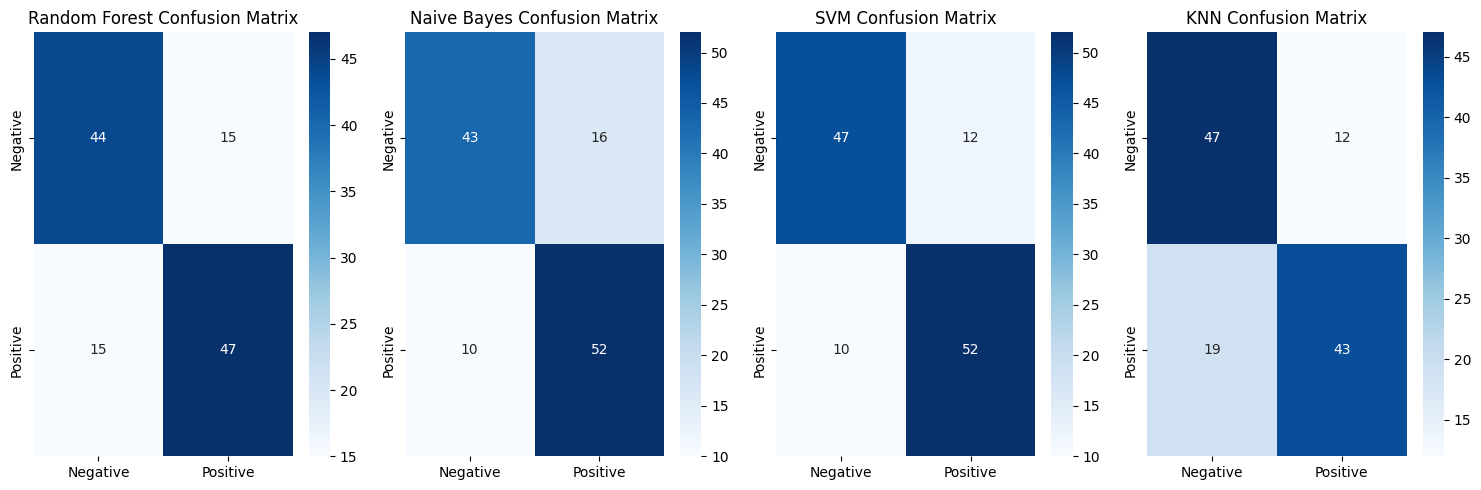

In [ ]:
# Random Forest
rf_conf_matrix = confusion_matrix(test_y1, test_predict)

# Naive Bayes
naive_bayes_conf_matrix = confusion_matrix(test_y1, naive_bayes_predict)

# SVM
svm_conf_matrix = confusion_matrix(test_y1, svm_predict)

# KNN
knn_conf_matrix = confusion_matrix(test_y1, knn_predict)

# Confusion matrixlerini görselleştirme
plt.figure(figsize=(15, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 4, 1)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Random Forest Confusion Matrix')

# Naive Bayes Confusion Matrix
plt.subplot(1, 4, 2)
sns.heatmap(naive_bayes_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Naive Bayes Confusion Matrix')

# SVM Confusion Matrix
plt.subplot(1, 4, 3)
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('SVM Confusion Matrix')

# KNN Confusion Matrix
plt.subplot(1, 4, 4)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('KNN Confusion Matrix')

plt.tight_layout()  # Alt başlıkların daha iyi yerleştirilmesi için
plt.show()


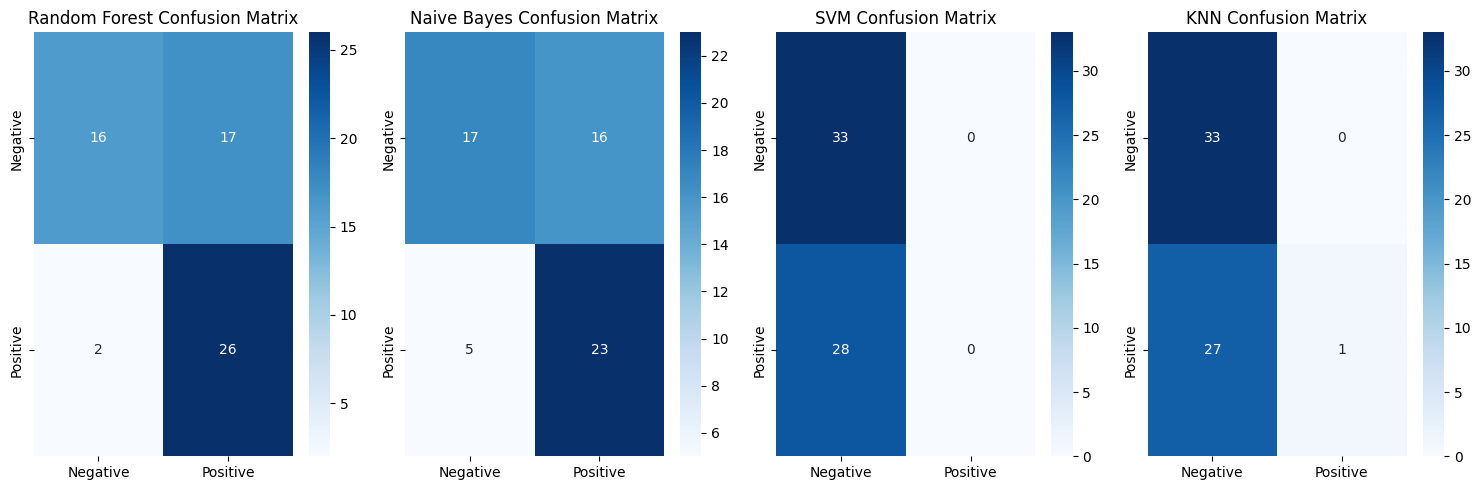

In [ ]:
# Random Forest
rf_conf_matrix = confusion_matrix(test_y1, test_predict)

# Naive Bayes
naive_bayes_conf_matrix = confusion_matrix(test_y1, naive_bayes_predict)

# SVM
svm_conf_matrix = confusion_matrix(test_y1, svm_predict)

# KNN
knn_conf_matrix = confusion_matrix(test_y1, knn_predict)

# Confusion matrixlerini görselleştirme
plt.figure(figsize=(15, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 4, 1)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Random Forest Confusion Matrix')

# Naive Bayes Confusion Matrix
plt.subplot(1, 4, 2)
sns.heatmap(naive_bayes_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Naive Bayes Confusion Matrix')

# SVM Confusion Matrix
plt.subplot(1, 4, 3)
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('SVM Confusion Matrix')

# KNN Confusion Matrix
plt.subplot(1, 4, 4)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('KNN Confusion Matrix')

plt.tight_layout()  # Alt başlıkların daha iyi yerleştirilmesi için
plt.show()


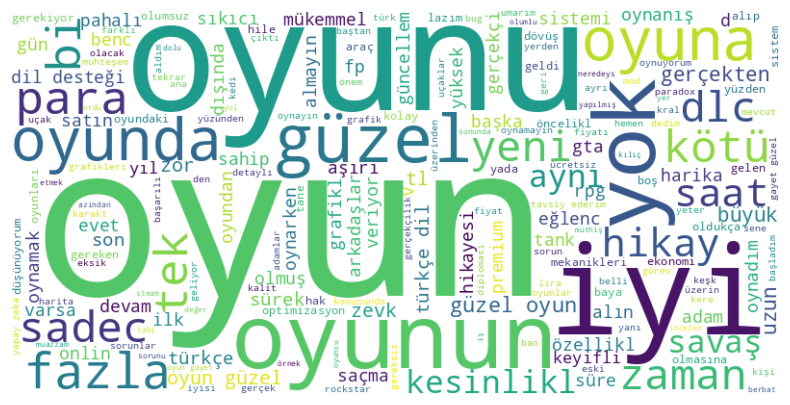

In [ ]:
# Tüm temizlenmiş metinleri birleştirin
all_cleaned_text = " ".join(cleaned_text_data)

# Kelime bulutu oluşturma
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)

# Kelime bulutunu görselleştirme
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # Bilinear interpolasyon yöntemiyle görseli oluştur
plt.axis('off')  # Eksenleri kapat
plt.show()


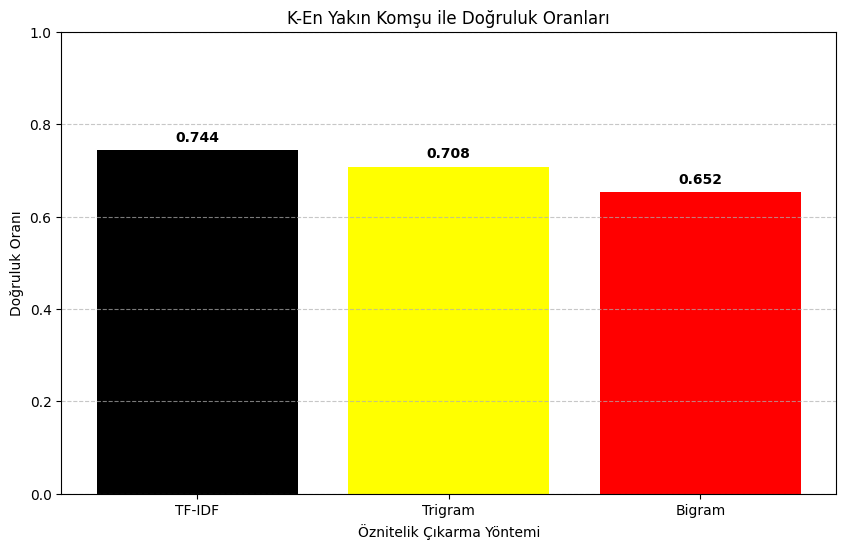

In [ ]:
feature_extraction_methods = ['TF-IDF', 'Trigram', 'Bigram']
accuracies = [0.74352942606524906, 0.707808945073941, 0.6522333556692662]
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_extraction_methods, accuracies, color=['black', 'yellow', 'red'])
plt.xlabel('Öznitelik Çıkarma Yöntemi')
plt.ylabel('Doğruluk Oranı')
plt.title('K-En Yakın Komşu ile Doğruluk Oranları')
plt.ylim(0, 1)  # Doğruluk oranı 0 ile 1 arasında olduğundan
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{accuracy:.3f}', ha='center', fontweight='bold')

plt.show()